## Table Mountain Sim
In lab sim between two B210s. The following are the simulation settings:
* 5.8 GHz Carrier
* 500 kHz signal
* Tx samp_rate 5M
* Rx samp_rate 5M
* Tx gain setting = 80 or 90
* Rx gain setting = 20 or 40 or 60
* Cable Loss between B210s = 1.64 dB


Here we're going to adjust the values from dB to dBV to dBm.

per Todd's instructions
https://github.com/NTIA/scos-algorithm-test/blob/6dc7840abc58e0743ed22938ce6bc463b6fe7fb0/scos_algorithm_test/lib/scos_algorithms/m4s.py#L70

### Measurements taken
| no.  | dB Attenuation  | Tx Gain | Rx Gain |
|---|---|---|---|
| 1  | 100  | 80  | 20  |
| 2  | 100  | 80  | 40  |
| 3  | 100  | 80  | 60  |
| 4  | 110  | 80  | 20  |
| 5  | 110  | 80  | 40  |
| 6  | 110  | 80  | 60  |
| 7  | 100  | 90  | 60  |
| 8  | 110  | 90  | 60  |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal

### Measurement 3

In [2]:
path = "/home/max/Workspace/Tablemountain/"
rec03 = "03_tone_recording_TX80_RX60.data"
rx_03_full = np.fromfile(file=path+rec03, dtype=np.complex64, count=-1)
print(len(rx_03_full)) ## should be 23741738 FOR 01 only

20650009


10240
2e-07 2e-07


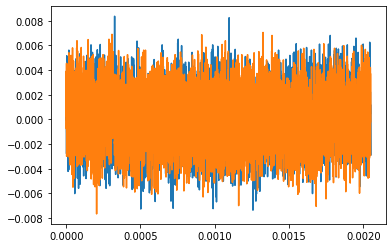

In [3]:
## let's take something from the center where the recording should be better
start = 10000000
length = 1024 * 10
rx_03 = rx_03_full[start: start+length]
print(len(rx_03))

## look at time domain
samp_rate = 5000000
T = 1/samp_rate
tt = np.linspace(0, (T*length)-T, length)
print(tt[1], T) ## should be the same
plt.plot(tt, rx_03.real, tt, rx_03.imag)
plt.show()

1024 <class 'numpy.complex128'>


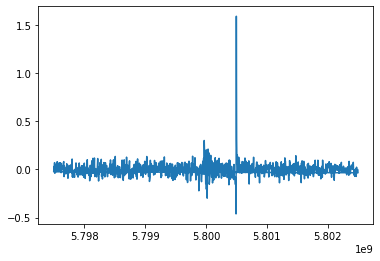

In [4]:
## look at freq domain, no windowing
freq = np.fft.fft(rx_03[1024*4:1024*5], n=1024)
print(len(freq), type(freq[0]))
x_axis = np.fft.fftfreq(n=1024,d=T) + 5800000000
plt.plot(x_axis, freq.real)
plt.show()

In [5]:
## adjust for B210 cal at 60dB rx gain
## gain_sigan = 49.82919278878725
## returns the IQ waveform at the input terminal
gain_sigan_60 = 49.82919278878725

## IQ_front = IQ_adc / 20log(gain_sigan) 
#rx_03_dBV = rx_03_full / (20 * np.log10(gain_sigan_60))
rx_03_dBV = rx_03_full / (10 ** (gain_sigan_60/20))

In [6]:
## Shorten
start = 10000000
length = 1024 * 10
complex_iq = rx_03_dBV[start: start+length]

## Reshape the IQ samples to prepare for the FFT
complex_iq = np.reshape(complex_iq, (10, 1024))

## Construct FFT window and apply it
#window = signal.windows.blackmanharris(1024)
window = signal.windows.flattop(1024)
## calculate the requested correction factor
window_correction = 1 # Assume no correction
correction_type = 'energy'
if correction_type == 'amplitude':
    window_correction = 1 / np.mean(window)
elif correction_type == 'energy':
    window_correction = np.sqrt( 1 / np.mean(window**2) )
complex_iq *= window

## Take the FFTs and normalize
complex_fft = np.fft.fftshift(np.fft.fft(complex_iq))

## Convert to pseudo-power (full power conversion will occur after detector)
complex_fft = np.square(np.abs(complex_fft))

# Create the detector result
m4s_detected = np.zeros((5,1024), dtype=np.float32)

# Run the detector
m4s_detected[0] = np.min(complex_fft, axis=0)
m4s_detected[1] = np.max(complex_fft, axis=0)
m4s_detected[2] = np.mean(complex_fft, axis=0)
m4s_detected[3] = np.median(complex_fft, axis=0)
for i in range(1024):
    m4s_detected[4][i] = complex_fft[np.random.randint(0,10)][i]

# Convert to power (dBm)
impedance_factor = -10*np.log10(50)
m4s_detected = 10*np.log10(m4s_detected) + impedance_factor + 30
m4s_detected -= 3 #Account for double sided FFT

# Normalize the FFT
fft_normalization_factor = -20*np.log10(len(m4s_detected[0]))
m4s_detected += fft_normalization_factor

# Apply window correction factor
window_correction = 20*np.log10(window_correction)
m4s_detected += window_correction
        
        
        

In [7]:
m4s_detected.shape

(5, 1024)

In [8]:
tt = np.sort(x_axis)

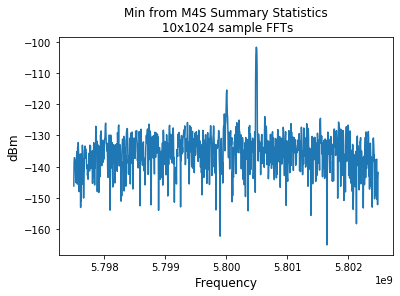

In [9]:
plt.plot(tt, m4s_detected[0])
plt.title('Min from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

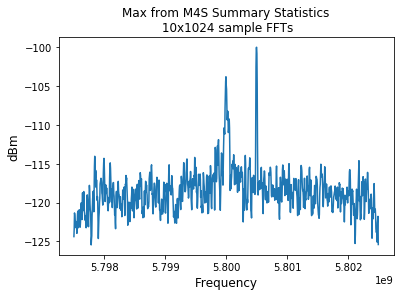

In [10]:
plt.plot(tt, m4s_detected[1])
plt.title('Max from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

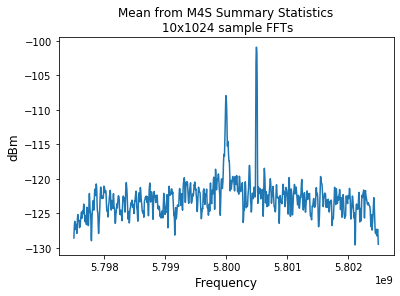

In [11]:
plt.plot(tt, m4s_detected[2])
plt.title('Mean from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

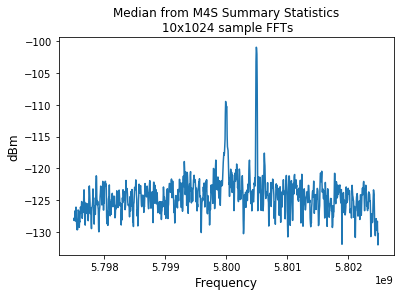

In [12]:
plt.plot(tt, m4s_detected[3])
plt.title('Median from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

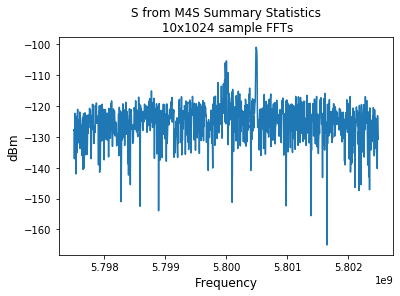

In [13]:
plt.plot(tt, m4s_detected[4])
plt.title('S from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

## Calculating the Noise Floor kTB
$\text{noisefloor}= 10 * \log_{10}(k * T * B)$

$k = 1.38 * 10^{-23}$

$T = 294$  Kelvin

$B = 5/1024$  MHz (Bandwidth is the size of your DFT bins)



$k*T*B = 1.9810*10^{-17}$  Watts

$= -136.9 \text{dBW} = -106.9 \text{dBm} $

$= -167.03 \text{dBW} = -137.03 \text{dBm} $


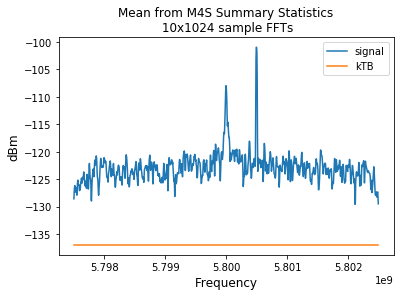

In [14]:
kTB = -137.0
kTB_a = np.zeros(1024) + kTB

plt.plot(tt, m4s_detected[2], tt, kTB_a)
plt.title('Mean from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.legend(('signal','kTB'))
plt.show()

Peak value = -100.94306945800781 dBm


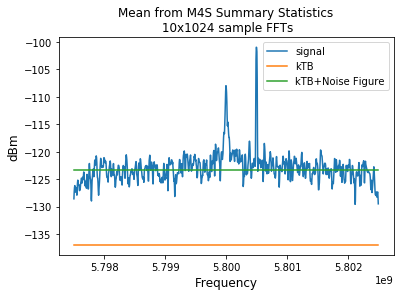

In [15]:
kTB = -137.0
kTB_a = np.zeros(1024) + kTB

noise_figure_sigan_60 = 13.75
kTB_and_noisefigure = kTB_a + noise_figure_sigan_60

print("Peak value = {} dBm".format(max(m4s_detected[2])))

plt.plot(tt, m4s_detected[2], tt, kTB_a, tt, kTB_and_noisefigure)
plt.title('Mean from M4S Summary Statistics\n 10x1024 sample FFTs')
plt.ylabel('dBm', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.legend(('signal','kTB','kTB+Noise Figure'))
plt.show()

In [16]:
print(kTB_and_noisefigure[0])

-123.25


## Calculate the noise figure
This is the noise in the receiver (added by amplifiers and mixers).

### From the b210 cal file

"calibration_data": {

    "noise_figure_sigan": 13.752314824758571,

    "enbw_sigan": 35536962.65798034,
    
    "1db_compression_sigan": -37.963379765999996,
    
    "gain_sigan": 49.82919278878725

},

"gain": 60.0
